In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score, roc_curve, auc, precision_score, recall_score
from sklearn.model_selection import KFold
import cv2

In [2]:
train_dir = "D:/mca/4th sem/major pj/DATASET'S/combined/train"
test_dir = "D:/mca/4th sem/major pj/DATASET'S/combined/test"

img_height, img_width = 224, 224
batch_size = 32
num_classes = 7  # <-- Update as per your dataset


In [3]:
# Data augmentation (stronger)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)


Found 46026 images belonging to 7 classes.
Found 11503 images belonging to 7 classes.
Found 14244 images belonging to 7 classes.


In [4]:
# Model with batch normalization and L2 regularization
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_mobilenet_fer_fine.h5', save_best_only=True, monitor='val_loss')
]

# Train (transfer learning)
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/40
1439/1439 [==============================] - 1319s 915ms/step - loss: 2.6788 - accuracy: 0.2967 - val_loss: 1.8416 - val_accuracy: 0.3651 - lr: 0.0010


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
1439/1439 [==============================] - 891s 619ms/step - loss: 1.8839 - accuracy: 0.3258 - val_loss: 1.8411 - val_accuracy: 0.3384 - lr: 0.0010
Epoch 3/40
1439/1439 [==============================] - 889s 618ms/step - loss: 1.8700 - accuracy: 0.3287 - val_loss: 1.8180 - val_accuracy: 0.3643 - lr: 0.0010
Epoch 4/40
1439/1439 [==============================] - 890s 618ms/step - loss: 1.8702 - accuracy: 0.3253 - val_loss: 1.8232 - val_accuracy: 0.3460 - lr: 0.0010
Epoch 5/40
1439/1439 [==============================] - 891s 619ms/step - loss: 1.8661 - accuracy: 0.3282 - val_loss: 1.8145 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 6/40
1439/1439 [==============================] - 894s 621ms/step - loss: 1.8593 - accuracy: 0.3306 - val_loss: 1.7978 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 7/40
1439/1439 [==============================] - 892s 620ms/step - loss: 1.8500 - accuracy: 0.3278 - val_loss: 1.7800 - val_accuracy: 0.3754 - lr: 0.0010
Epoch 8/40
1439/1439 [============

In [6]:
# Fine-tuning: unfreeze more layers
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Unfreeze last 50 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/60
1439/1439 [==============================] - 1230s 852ms/step - loss: 1.4394 - accuracy: 0.4550 - val_loss: 1.3030 - val_accuracy: 0.5007 - lr: 1.0000e-04
Epoch 2/60
1439/1439 [==============================] - 1254s 871ms/step - loss: 1.2646 - accuracy: 0.5323 - val_loss: 1.2054 - val_accuracy: 0.5458 - lr: 1.0000e-04
Epoch 3/60
1439/1439 [==============================] - 1169s 813ms/step - loss: 1.1916 - accuracy: 0.5628 - val_loss: 1.0851 - val_accuracy: 0.5961 - lr: 1.0000e-04
Epoch 4/60
1439/1439 [==============================] - 1187s 824ms/step - loss: 1.1441 - accuracy: 0.5774 - val_loss: 1.0618 - val_accuracy: 0.6122 - lr: 1.0000e-04
Epoch 5/60
1439/1439 [==============================] - 1176s 817ms/step - loss: 1.1090 - accuracy: 0.5949 - val_loss: 1.0186 - val_accuracy: 0.6257 - lr: 1.0000e-04
Epoch 6/60
1439/1439 [==============================] - 1180s 820ms/step - loss: 1.0844 - accuracy: 0.6035 - val_loss: 0.9580 - val_accuracy: 0.6523 - lr: 1.0000e-04
Epoc

In [7]:

model.save('best_mobilenet_fer_final.keras') 


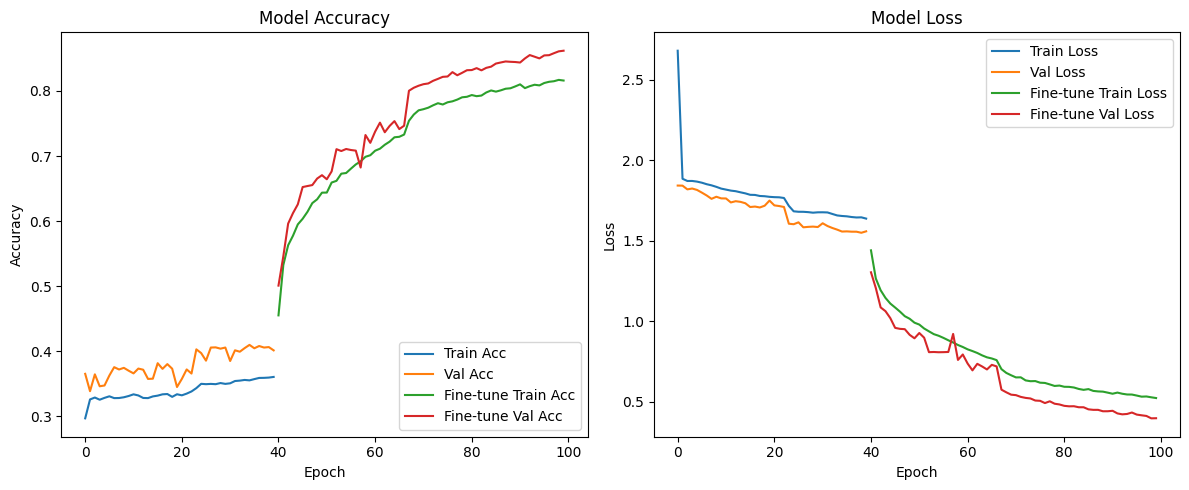

In [8]:
# Plot training history
def plot_training_history(history, history_finetune=None):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    if history_finetune:
        offset = len(history.history['accuracy'])
        plt.plot(range(offset, offset + len(history_finetune.history['accuracy'])),
                 history_finetune.history['accuracy'], label='Fine-tune Train Acc')
        plt.plot(range(offset, offset + len(history_finetune.history['val_accuracy'])),
                 history_finetune.history['val_accuracy'], label='Fine-tune Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    if history_finetune:
        offset = len(history.history['loss'])
        plt.plot(range(offset, offset + len(history_finetune.history['loss'])),
                 history_finetune.history['loss'], label='Fine-tune Train Loss')
        plt.plot(range(offset, offset + len(history_finetune.history['val_loss'])),
                 history_finetune.history['val_loss'], label='Fine-tune Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_finetune)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = "D:/mca/4th sem/major pj/DATASET'S/combined/test"
img_height, img_width = 224, 224  # Change if your model uses a different size
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' if only 2 classes
    shuffle=False
)


Found 14244 images belonging to 7 classes.


446/446 [==============================] - 230s 515ms/step


<Figure size 800x600 with 0 Axes>

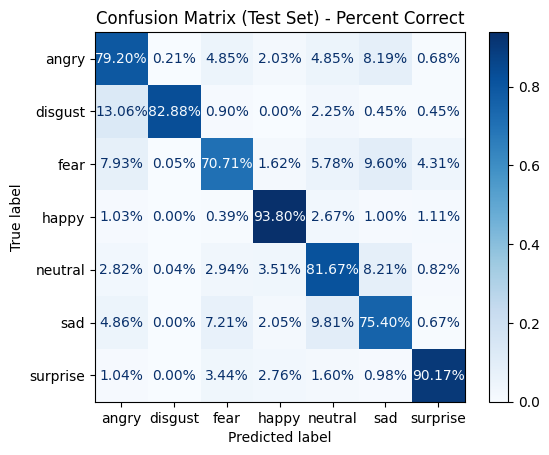

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = generator.classes
class_labels = list(generator.class_indices.keys())
y_pred = model.predict(generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Normalize confusion matrix here
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='.2%')  # No 'normalize' here
plt.title('Confusion Matrix (Test Set) - Percent Correct')
plt.show()


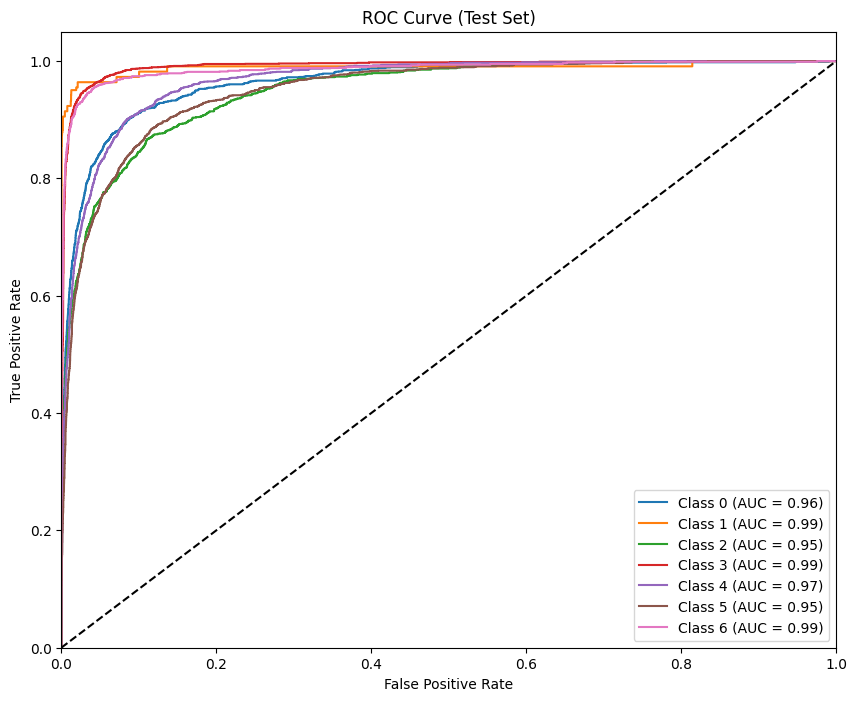

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_true is in the correct format (integer class indices)
# y_pred is the output of model.predict(generator)

num_classes = y_pred.shape[1]  # Number of columns = number of classes

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    # Create binary labels for the current class
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()


In [18]:
# Get true labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Get predicted logits and convert to probabilities
y_pred_logits = model.predict(test_generator)
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1).numpy()
y_pred = np.argmax(y_pred_prob, axis=1)

# F1 Score (macro)
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 Score (macro):', f1)

446/446 [==============================] - 228s 511ms/step
F1 Score (macro): 0.82840208918912


In [19]:
# Precision and Recall (macro and per-class)
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro): {recall_macro:.4f}')
for idx, label in enumerate(class_labels):
    print(f'Class {label}: Precision={precision_per_class[idx]:.4f}, Recall={recall_per_class[idx]:.4f}')

Precision (macro): 0.8393
Recall (macro): 0.8198
Class angry: Precision=0.7794, Recall=0.7920
Class disgust: Precision=0.9684, Recall=0.8288
Class fear: Precision=0.7793, Recall=0.7071
Class happy: Precision=0.9305, Recall=0.9380
Class neutral: Precision=0.7776, Recall=0.8167
Class sad: Precision=0.7477, Recall=0.7540
Class surprise: Precision=0.8919, Recall=0.9017
